Mona Mokart

# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP-Trees-YOUR-SURNAME.ipynb') with your answers and the code before the deadline.

We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [3]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

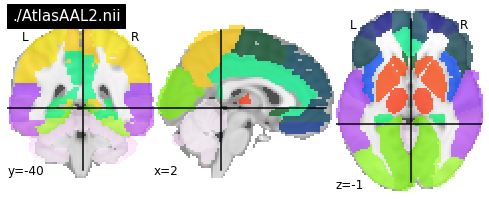

In [4]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [5]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

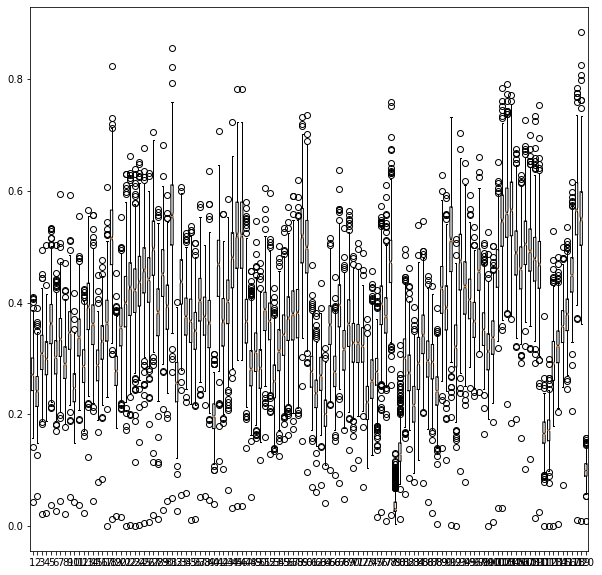

In [6]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

# Standardization/Normalization
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [7]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7814569536423841


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 


The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  2


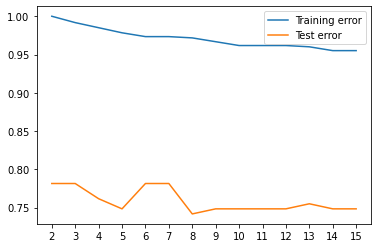

In [8]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train, y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)

plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  14


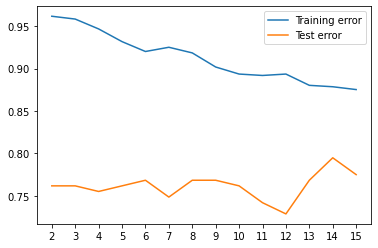

In [9]:
# min_samples_leaf
TTest2=[]
TTrain2=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train, y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain2.append(scoreTrain)
    TTest2.append(scoreTest)

plt.plot(TTrain2,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain2.index(max(TTrain2))+2)
plt.plot(TTest2,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the test score is : ",TTest2.index(max(TTest2))+2)
plt.legend();

**Réponse** : En changeant le split pour contruire le train set et le test set, on remarque que les paramètres sélectionnés changent également. Cela peut-être dû au fait qu'on n'a pas préalablement mélangé les données avant de split et que la selection des meilleurs paramètres n'est pas assez généralisée.

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

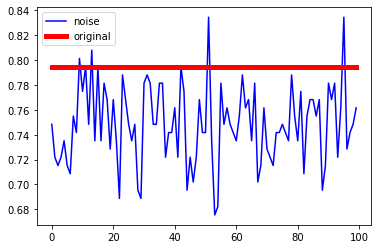

In [10]:
Tree = DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=14,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train, y_train)
scoreTest[:] = Tree.score(X_test, y_test)

for k in range(100):    
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i]+= np.abs(np.random.normal(0, 0.05))
        
    Tree.fit(X_train_temp, y_train)
    scoreTestnoise[k] = Tree.score(X_test, y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

**Réponse** : Les résultats ne sont pas stables et reflètent le caractère instable du bruit. On remarque qu'en moyenne les scores sur le test set sont moins bons quand on a ajouté du bruit au train set car cela biaise les prédictions. En effet ici le train set ne représente pas le type de données qu'on trouve en général et dans le test set, et donc en entrainant desus on obtient une moins bonne prédiction.

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

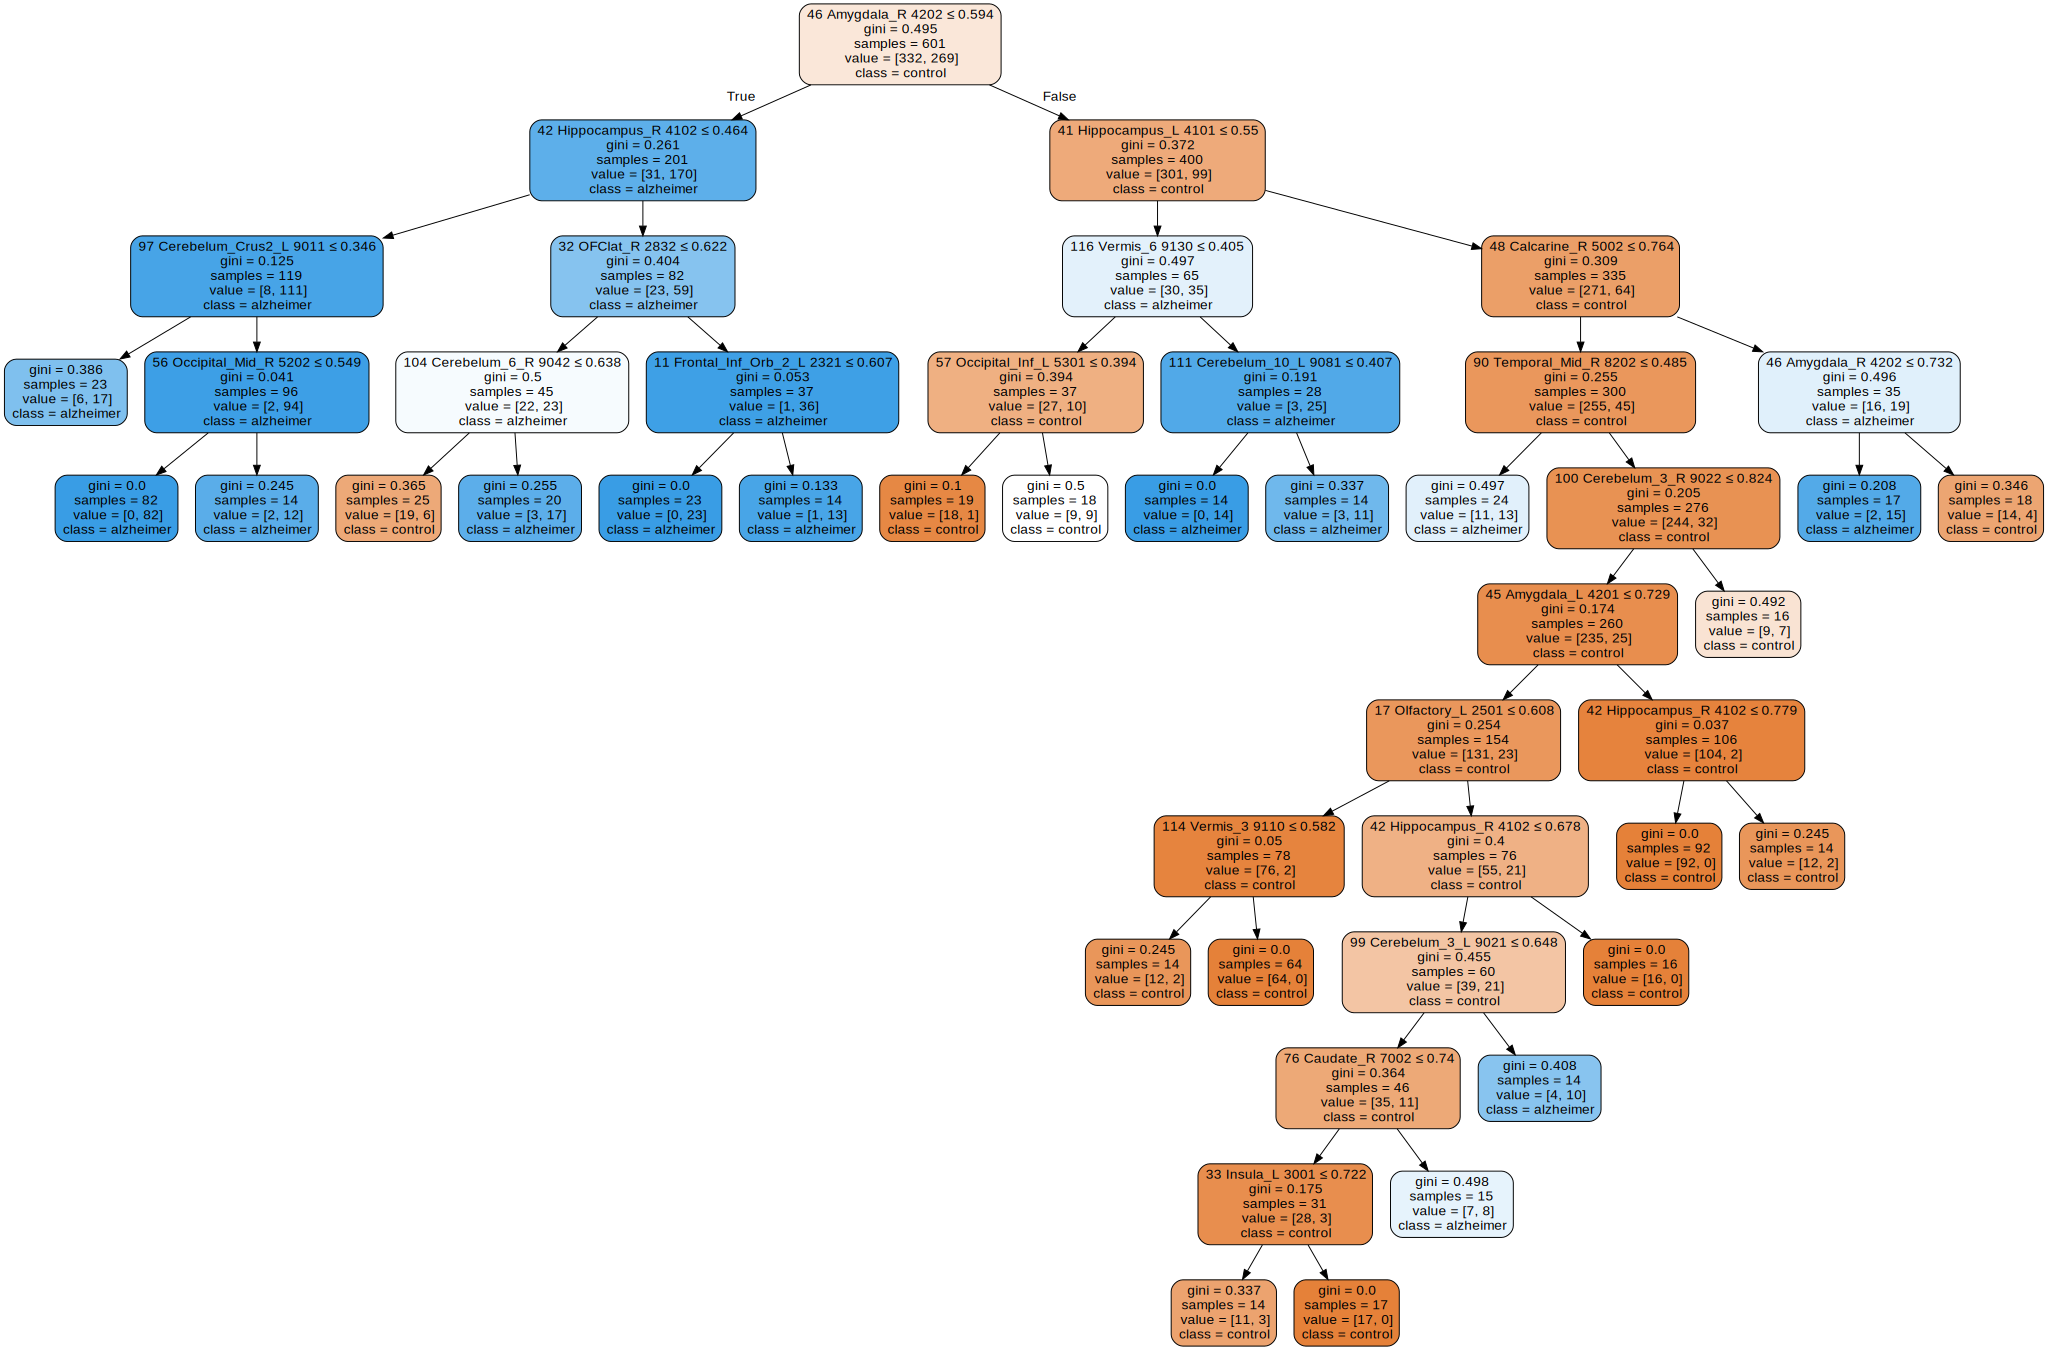

In [11]:
import graphviz 

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

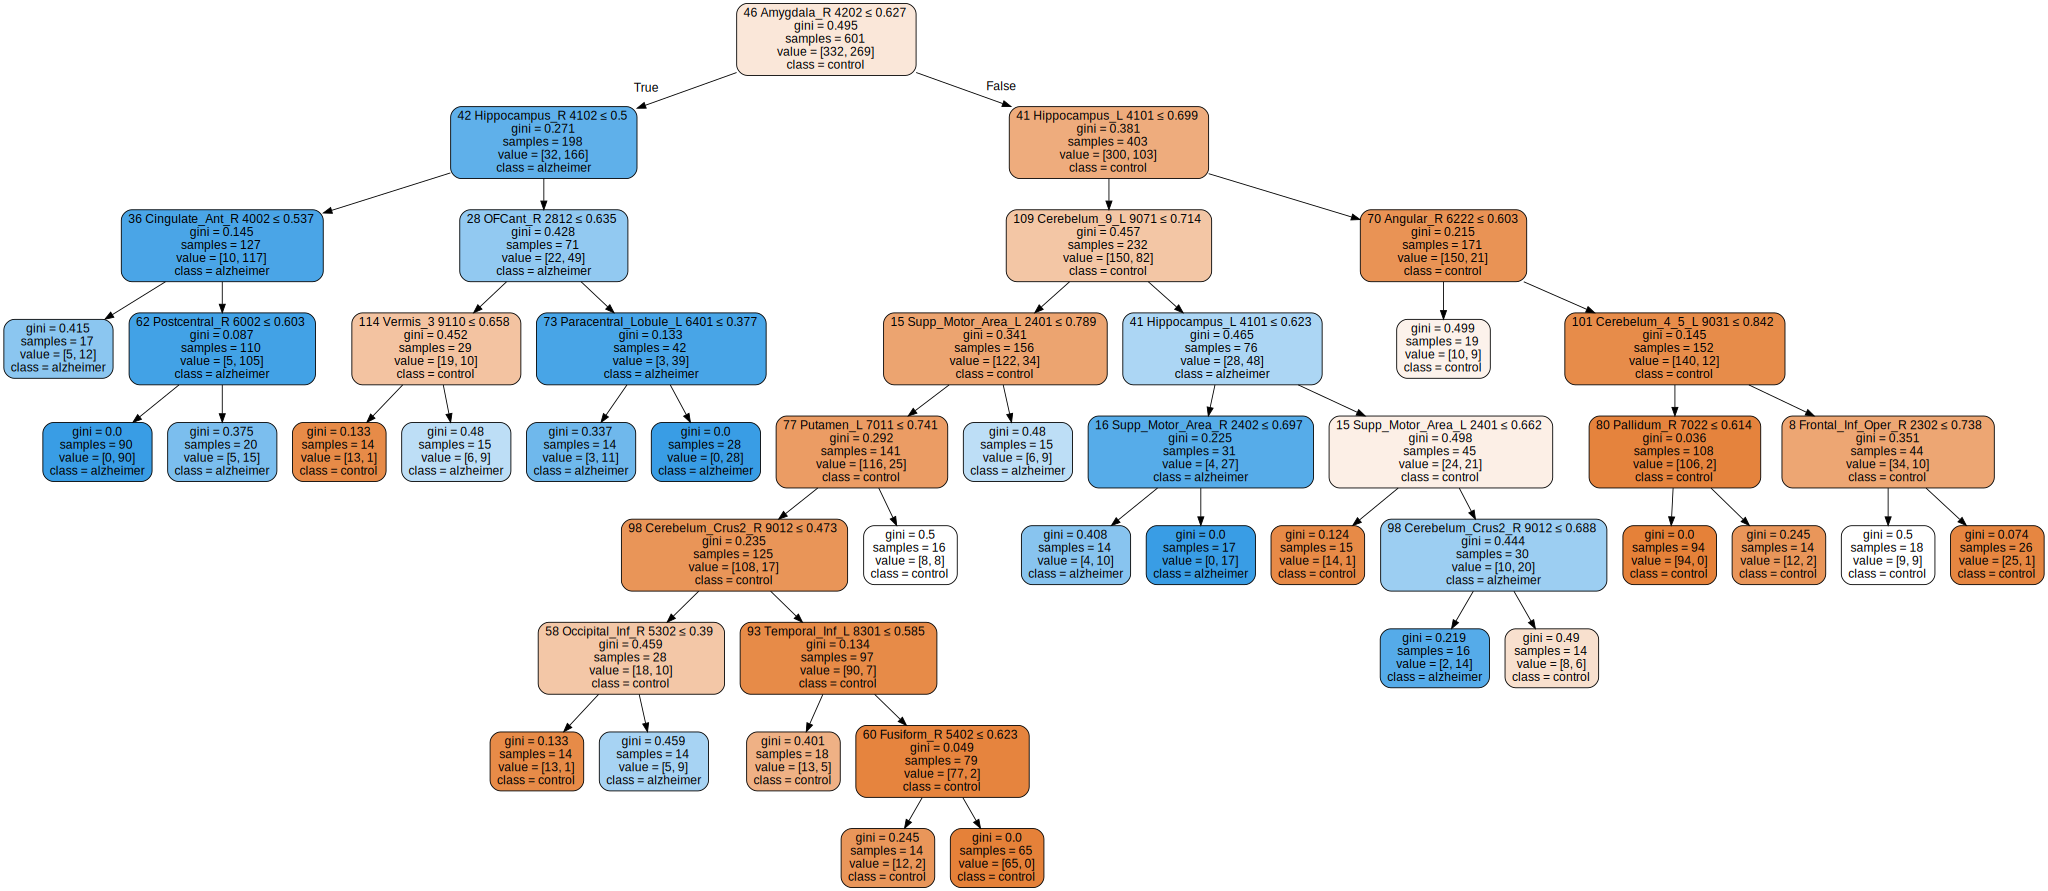

In [12]:
Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

**Réponse** : Si on ne mélange pas la data au début avant de créer les train et test sets, on remarque que les premiers splits des arbres se font selon les mêmes features (avec des taux différents) mais les arbres se différencient sur les noeuds plus bas. 

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

In [16]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
              'min_samples_leaf': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], } 
grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, scoring='accuracy', cv=5 )
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test, y_test))

Best Validation Score: 0.7654269972451792
Best params: {'min_samples_leaf': 7, 'min_samples_split': 2}
Tree test score : 0.7483443708609272


**Réponse** : Les hyper-paramètres séléctionnés ne sont pas les mêmes car préceddement nous avions entrainé une seule fois sur le train set sans même le mélanger. Ici la cross validation permet de mieux géneraliser les paramêtres.
J'ai utilisé score accuracy car ici il n'y a pas de problème de classe majoritaire : en terme de proportion les deux classes sont représentées à peu près de la même façon. Si il y avait une grande différence dans les proportions on aurait pu utiliser balanced_accuracy ou f1.

Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

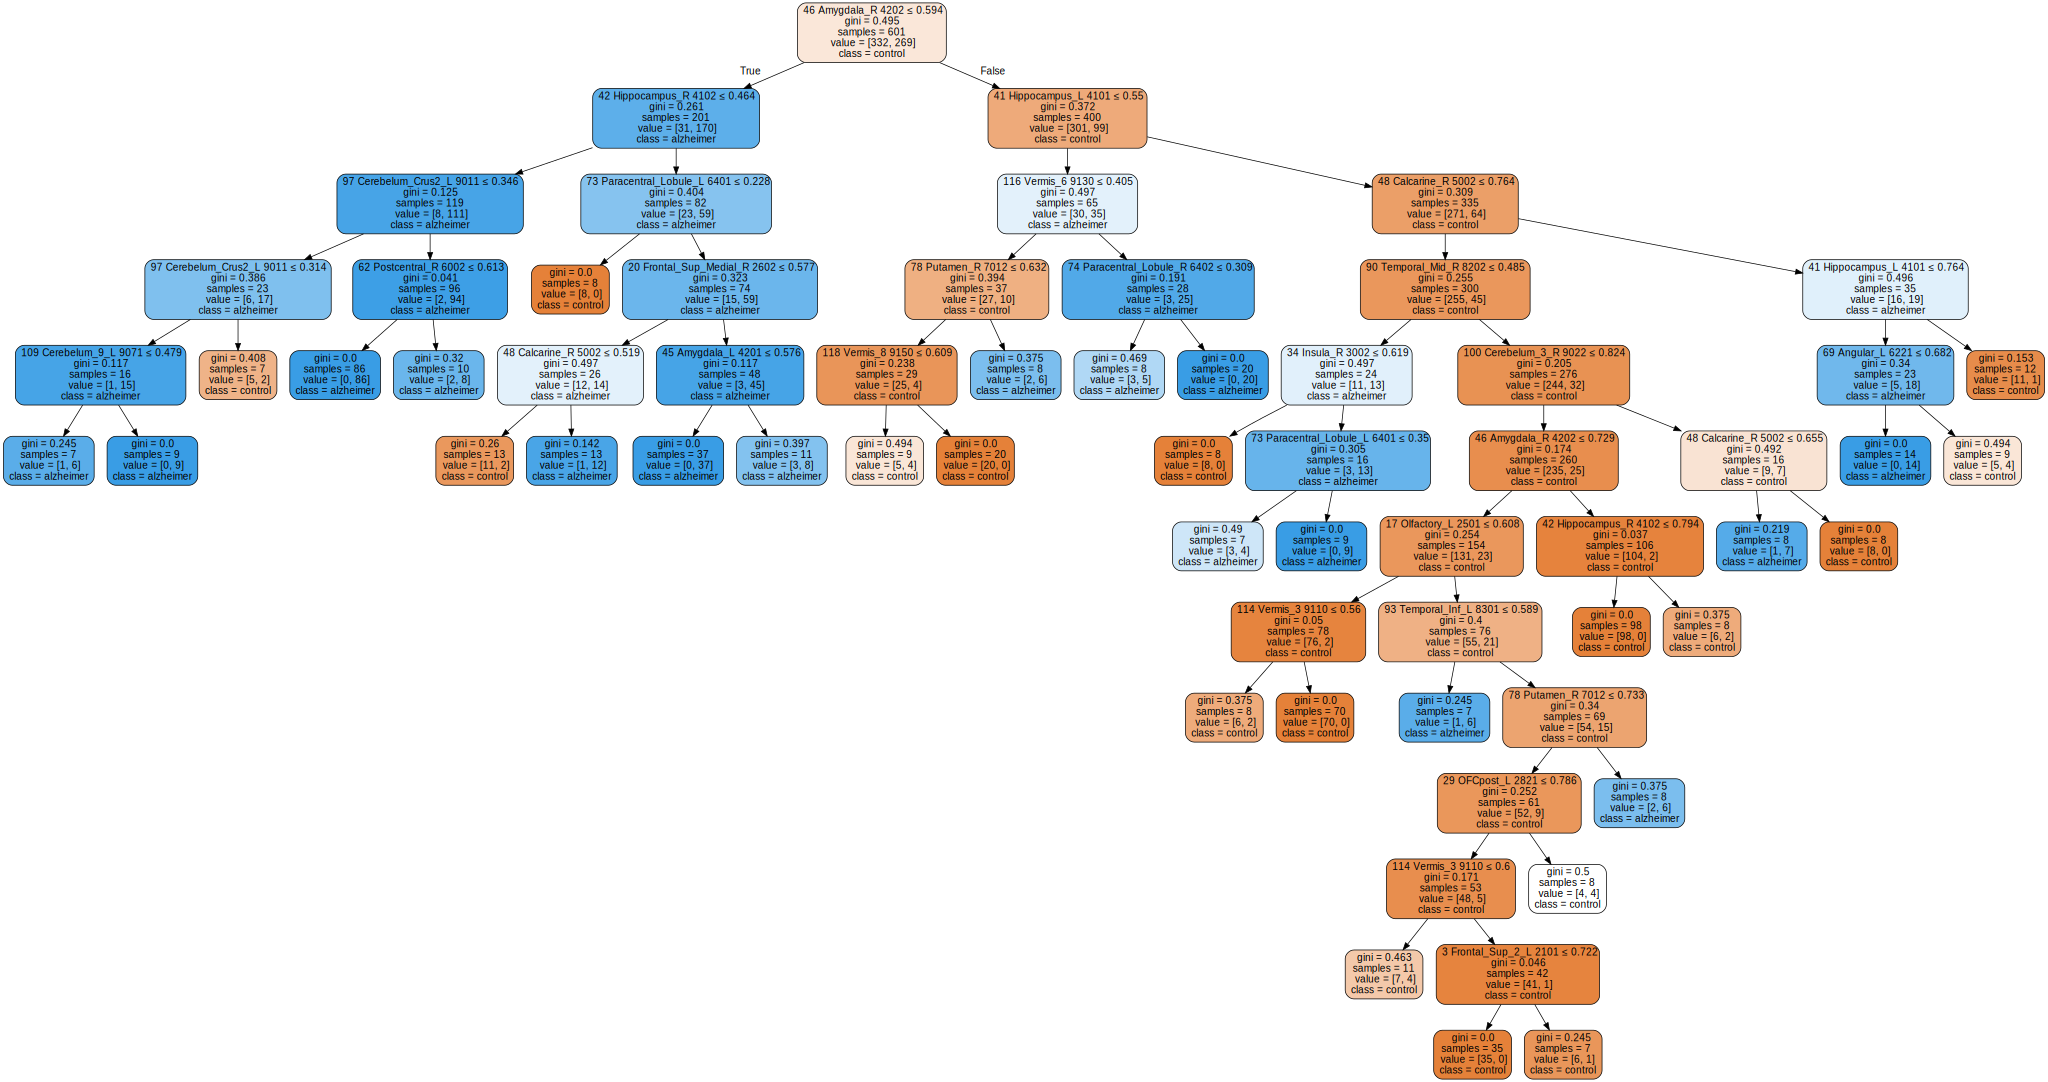

In [14]:
Tree = DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=7,random_state=0)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

**Réponse** : L'abre n'est pas totalement le même que le premier mais il est vrai qu'au niveau de la racine de l'arbre, les ROIs sont les mêmes. Cela signifie traiter et comparer ces ROIs pour faire le diagnostic est la façon la plus efficace. Ces ROIs sont les plus importantes pour determiner le résultat.

En comparant en premier la ROI 46 on fait déjà un bon tri. Par la suite pour trier les noeuds suivants avec autant de précision il faut faire une longue succession de split. Cependant si on impose des critères d'arrets (min_sample_split et min_sample_leaf) trop précis (donc trop petits) cela peut créer de l'overfitting. 

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

In [22]:
Tree = DecisionTreeClassifier(min_samples_leaf=7,min_samples_split=2, random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid= p_grid_bagging, cv=5, scoring ='accuracy')
grid_bagging.fit(X_train, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test, y_test))

Best Validation Score: 0.7986501377410468
Best params: {'n_estimators': 20}
Bagging test score : 0.8278145695364238


In [24]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf=7,min_samples_split=2, random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid= p_grid_bagging, cv=5, scoring ='accuracy')
grid_bagging.fit(X_train_temp, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test, y_test))

Best Validation Score: 0.8135812672176309
Best params: {'n_estimators': 10}
Bagging test score : 0.7814569536423841


**Réponse** : Il n'y a pas trop de difference dans les scores entre la version originelle et la bruitée, cependant le meilleur paramèetre selectionné n'est pas le même.
De façon globale les scores sont meilleurs avec bagging, et les scores sur le test set sont proches de ceux sur le train set. Ainsi il ne semble pas avoir d'overfitting.

The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [26]:
RF = RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test, y_test))

Best Validation Score: 0.831969696969697
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 30}
Random Forest test score : 0.8278145695364238


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

In [29]:
# Random Forest on noisy data
RF = RandomForestClassifier(random_state=0, n_estimators=30, min_samples_leaf=2, max_features="sqrt")
RF.fit(X_train_temp, y_train.ravel())

print("Training score:", RF.score(X_train_temp, y_train))
print("Test score :", RF.score(X_test, y_test))

Training score: 0.9966722129783694
Test score : 0.8145695364238411


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.089454)
2. feature 44 representing 45 Amygdala_L 4201
 (0.076285)
3. feature 40 representing 41 Hippocampus_L 4101
 (0.043547)
4. feature 43 representing 44 ParaHippocampal_R 4112
 (0.040923)
5. feature 93 representing 94 Temporal_Inf_R 8302
 (0.037989)
6. feature 92 representing 93 Temporal_Inf_L 8301
 (0.034526)
7. feature 59 representing 60 Fusiform_R 5402
 (0.032778)
8. feature 41 representing 42 Hippocampus_R 4102
 (0.032156)
9. feature 69 representing 70 Angular_R 6222
 (0.016868)
10. feature 86 representing 87 Temporal_Pole_Sup_L 8121
 (0.016329)


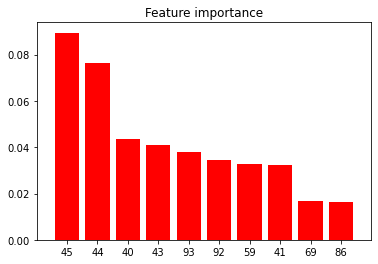

In [35]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

**Réponse** : Les deux plus importantes features sont Amygdala_R et Amygdala_L. Mais plus généralement, ce sont les Amygdales, les hippocampes, les lobes temporaux inferieurs et le gyrus parahippocampique droit qui sont les régions les plus importantes.

Dans les deux papiers on relève l'importance des amygdales et de l'hyppocampes et des lobes temporaux, que ce soit réfléchi biologiquement ou informatiquement (machine learning).

- "The hippocampus is amongst the few structures of the medial temporal lobe that undergo severe structural changes in AD", *AlzheimerPaper*
- "Among recent studies, Tang et al. (2016) used volumetric, shape, and diffusion features of the hippocampus and amygdala for AD classification", *AlzheimerPaper*



We can also inspect the data using only pairs of the most important features

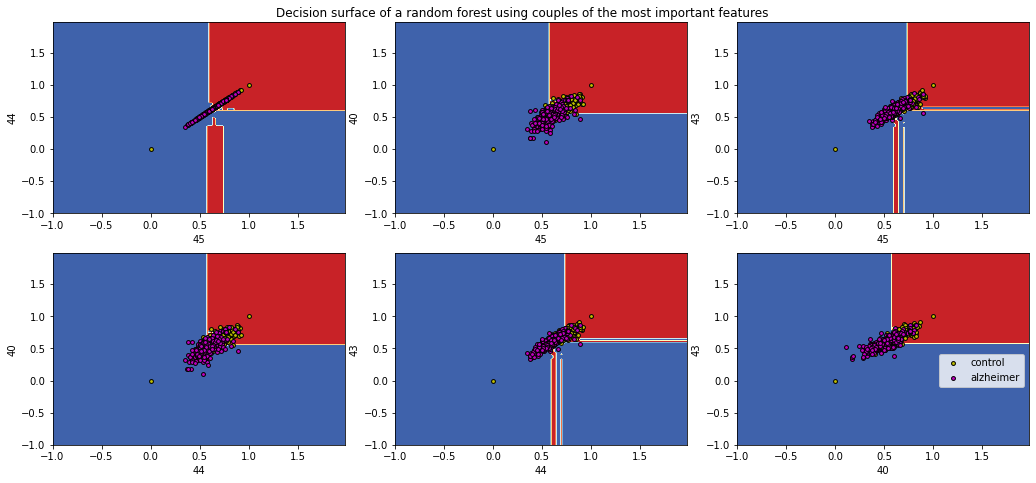

In [33]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair.ravel())

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

La meilleure paire de features semblent être 44-40 (ou 45-40 car 45 et 44 sont corrélées), car elles ne sont pas très correlées donc contiennent assez d'information et qu'elles semblent sur le graphe bien classer les données.

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

AICHA

In [37]:
X=T1AICHA
labels=ROIlabelsAICHA
atlas='./AtlasAICHA.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
RF = RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test, y_test))

Best Validation Score: 0.7687741046831956
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 30}
Random Forest test score : 0.7682119205298014


Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.067248)
2. feature 187 representing 188	N_Thalamus-5	189
 (0.031075)
3. feature 172 representing 173	N_Amygdala-1	174
 (0.030549)
4. feature 188 representing 189	N_Thalamus-6	190
 (0.027394)
5. feature 189 representing 190	N_Thalamus-7	191
 (0.025274)
6. feature 74 representing 75	G_Insula-anterior-3	76
 (0.021537)
7. feature 186 representing 187	N_Thalamus-4	188
 (0.020703)
8. feature 170 representing 171	G_Fusiform-6	172
 (0.020588)
9. feature 173 representing 174	N_Caudate-1	175
 (0.019986)
10. feature 183 representing 184	N_Thalamus-1	185
 (0.019236)


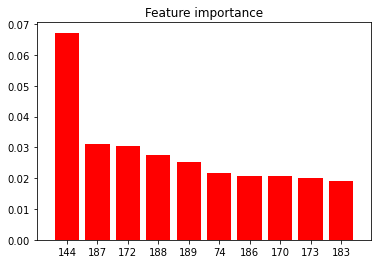

In [39]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

HAMMER

Best Validation Score: 0.82866391184573
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 30}
Random Forest test score : 0.8278145695364238
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.109515)
2. feature 2 representing Left Amygdala                          (0.082363)
3. feature 0 representing Left Hippocampus                       (0.081501)
4. feature 1 representing Right Hippocampus                      (0.058756)
5. feature 4 representing Left Anterior Medial Temporal Lobe     (0.035131)
6. feature 46 representing Left Lateral Temporal Ventricle        (0.034180)
7. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.033969)
8. feature 5 representing Right Anterior Medial Temporal Lobe    (0.031554)
9. feature 12 representing Left Inferior Middle Temporal Gyri     (0.028950)
10. feature 47 representing Right Lateral Temporal Ventricle       (0.023536)


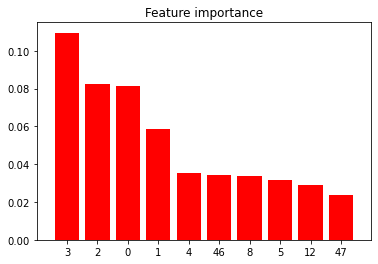

In [40]:
X=T1HAMMERS
labels=ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii'

 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

RF = RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test, y_test))

best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

On retrouve les mêmes features majoritaires que pour AAL2. L'atlas AICHA révèle "Parietooccipital" et le Thalamus, mais les amygdales sont encore évoquées. Finalement les amygdales et l'hypoccampe sont des zones importantes pour determiner le diagnostic